In [1]:
import pandas as pd

df = pd.read_csv('data/data.csv')

df.head()

,Time,Protcol,Flag,Family,Clusters,SeddAddress,ExpAddress,BTC,USD,Netflow_Bytes,IPaddress,Threats,Port,Prediction
0,50,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,500,5,A,Bonet,5061,SS
1,40,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,504,8,A,Bonet,5061,SS
2,30,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,508,7,A,Bonet,5061,SS
3,20,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,512,15,A,Bonet,5061,SS
4,57,TCP,A,WannaCry,1,1DA11mPS,1BonuSr7,1,516,9,A,Bonet,5061,SS


In [2]:
df.info()
df.describe() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149043 entries, 0 to 149042
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Time           149043 non-null  int64 
 1   Protcol        149043 non-null  object
 2   Flag           149043 non-null  object
 3   Family         149043 non-null  object
 4   Clusters       149043 non-null  int64 
 5   SeddAddress    149043 non-null  object
 6   ExpAddress     149043 non-null  object
 7   BTC            149043 non-null  int64 
 8   USD            149043 non-null  int64 
 9   Netflow_Bytes  149043 non-null  int64 
 10  IPaddress      149043 non-null  object
 11  Threats        149043 non-null  object
 12  Port           149043 non-null  int64 
 13  Prediction     149043 non-null  object
dtypes: int64(6), object(8)
memory usage: 15.9+ MB


,Time,Clusters,BTC,USD,Netflow_Bytes,Port
count,149043.000000,149043.000000,149043.000000,149043.000000,149043.000000,149043.000000
mean,21.466979,2.349295,30.554605,14863.441114,2021.278651,5063.949967
std,15.883598,2.828759,101.447102,26849.434659,2271.420987,2.696011
min,-10.000000,1.000000,1.000000,1.000000,1.000000,5061.000000
25%,8.000000,1.000000,8.000000,512.000000,353.000000,5062.000000
50%,19.000000,1.000000,13.000000,4321.000000,1031.000000,5062.000000
75%,32.000000,2.000000,22.000000,18454.000000,3188.000000,5066.000000
max,96.000000,12.000000,1980.000000,126379.000000,12360.000000,5068.000000


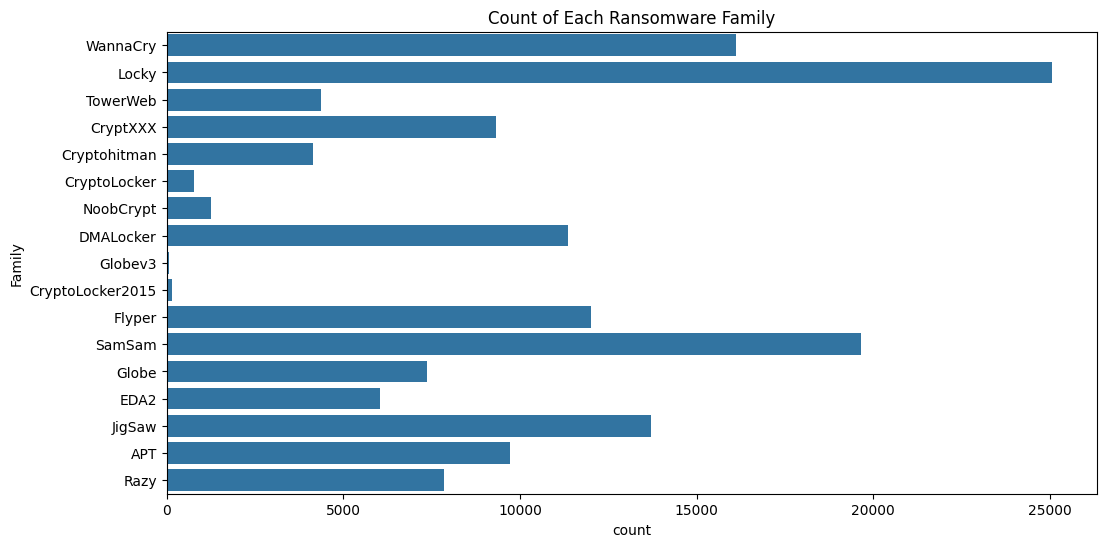

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Family') 
plt.title('Count of Each Ransomware Family')
plt.show()


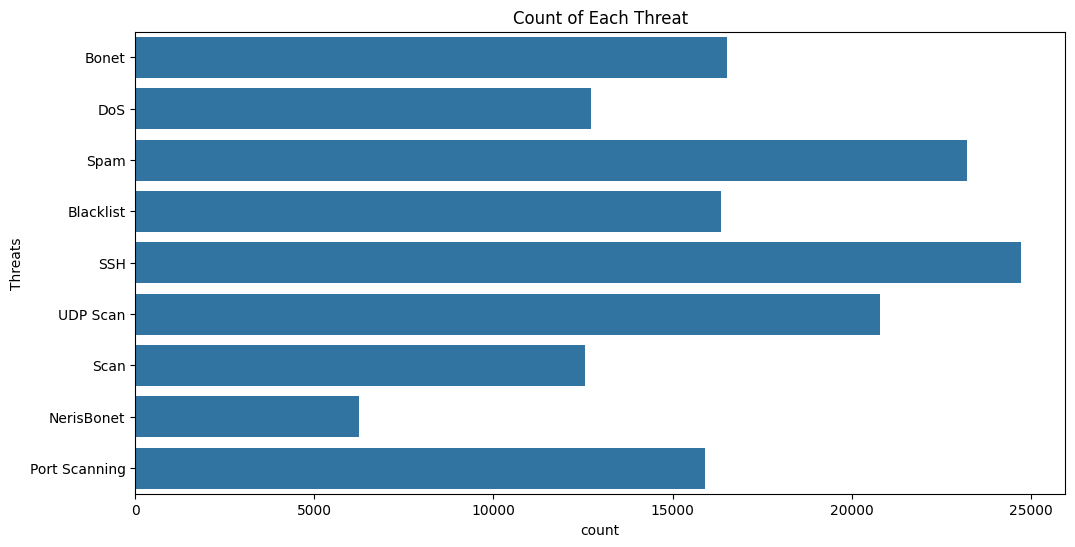

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Threats')
plt.title('Count of Each Threat')
plt.show()

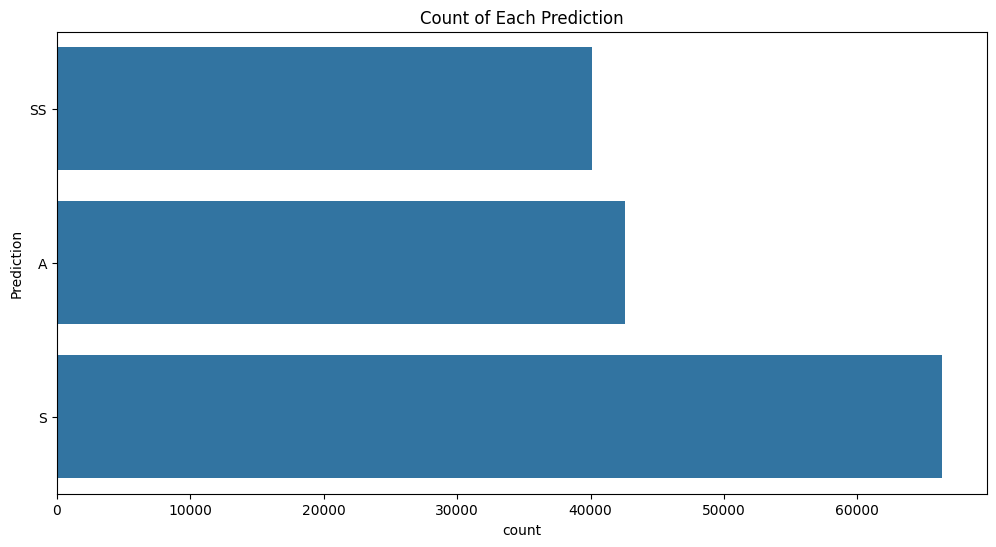

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Prediction')
plt.title('Count of Each Prediction')
plt.show()

In [6]:
df = df[df['Time'] >= 0]

df.reset_index(drop=True, inplace=True)
df.shape

(148904, 14)

In [7]:
df = df[df['ExpAddress'] != '1']
df.shape

(148831, 14)

Splitting the data into a 70/30 split. 70% is left for the unlabeled pool, 30% is left for the unlabeled pool. In this unlabeled pool there is 20% reserved for a validation pool, and then 80% left for unlabeled training. This means the machine learning I am trying to achieve with this specific dataset is semi-supervised learning. 

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# fix the column  typo
df.rename(columns={'Protcol': 'Protocol'}, inplace=True)

# Drop ID-like columns that won't be used in the model
df_cleaned = df.drop(columns=['SeddAddress', 'ExpAddress', 'IPaddress'])

le = LabelEncoder()
y_full = le.fit_transform(df_cleaned['Prediction'])


# drop the original text 'Prediction' column
features_df = df_cleaned.drop(columns=['Prediction'])

# define columns to one-hot encode
categorical_features = ['Protocol', 'Flag', 'Family', 'Threats']

# create the encoded features DataFrame
X_full = pd.get_dummies(features_df, columns=categorical_features, drop_first=True)



# separate 30% of the data to be  'labeled' pool
X_labeled_pool, X_unlabeled, y_labeled_pool, y_unlabeled = train_test_split(
    X_full, y_full, 
    test_size=0.70, # 70% of data becomes the 'unlabeled' set
    random_state=42, 
    stratify=y_full
)

# split the labeled pool into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled_pool, y_labeled_pool, 
    test_size=0.20, # 20% of the labeled pool becomes the validation set
    random_state=42, 
    stratify=y_labeled_pool
)

# --- Verification ---
print("--- Data Shapes ---")
print(f"Labeled Training Set (X_train): {X_train.shape}")
print(f"Validation Set (X_val):       {X_val.shape}")
print(f"Unlabeled Set (X_unlabeled):  {X_unlabeled.shape}")

--- Data Shapes ---
Labeled Training Set (X_train): (35719, 40)
Validation Set (X_val):       (8930, 40)
Unlabeled Set (X_unlabeled):  (104182, 40)


In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# initialize the Random Forest Classifier
baseline_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# train model only on labeled data
baseline_model.fit(X_train, y_train)
# make predictions on the validation set
predictions = baseline_model.predict(X_val)
# evaluate the model
accuracy = accuracy_score(y_val, predictions)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
# detailed classification report
print(classification_report(y_val, predictions))

Validation Accuracy: 99.10%
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2549
           1       0.99      0.99      0.99      3980
           2       0.99      0.99      0.99      2401

    accuracy                           0.99      8930
   macro avg       0.99      0.99      0.99      8930
weighted avg       0.99      0.99      0.99      8930



In [10]:
import pandas as pd

# Get feature importances from the first model you trained
importances = baseline_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the table
feature_importance_df

,Feature,Importance
3,USD,0.259485
2,BTC,0.133838
1,Clusters,0.094286
4,Netflow_Bytes,0.077137
11,Flag_APS,0.066992
5,Port,0.061481
12,Flag_APSF,0.054247
6,Protocol_TCP,0.034470
8,Flag_AF,0.025839
14,Flag_ASF,0.024074


As we can see with the graph above, the importance scores show that there is no one singular strong performer, meaning there is little to no data leakage, and clusters (a normally important metric to check when it comes to data leakage) does not hold much of an importance significance meaning that the training model is mostly accurate and does not use any cheats. 

In [11]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore', category=UserWarning) #this is purely to hide an error relating to RandomForestClassifier

# get predicited probabilities for unlabeled data using baseline
print("Making predictions on unlabeled data...")
unlabeled_probabilities = baseline_model.predict_proba(X_unlabeled)

# find the model's confidence in its top prediction for each sample
confidence_scores = np.max(unlabeled_probabilities, axis=1)

# set a confidence threshold
confidence_threshold = 0.98

# filter for high-confidence predictions
high_confidence_mask = confidence_scores > confidence_threshold
X_pseudo_labeled = X_unlabeled[high_confidence_mask]
pseudo_labels = baseline_model.predict(X_pseudo_labeled)

print(f"Found {len(X_pseudo_labeled)} samples with >{confidence_threshold*100}% confidence.")

# combine the original training set with the new pseudo-labeled set
X_combined_train = np.vstack([X_train, X_pseudo_labeled])
y_combined_train = np.hstack([y_train, pseudo_labels])

# train a new model on the larger, combined dataset
print("Training new model on combined data...")
semi_supervised_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
semi_supervised_model.fit(X_combined_train, y_combined_train)
print("Training complete.")

# evaluate the new model on the same validation set
new_predictions = semi_supervised_model.predict(X_val)
new_accuracy = accuracy_score(y_val, new_predictions)

# compare results
print(f"Original Baseline Model Accuracy: {accuracy * 100:.2f}%")
print(f"New Semi-Supervised Model Accuracy: {new_accuracy * 100:.2f}%")

Making predictions on unlabeled data...
Found 91119 samples with >98.0% confidence.
Training new model on combined data...
Training complete.
Original Baseline Model Accuracy: 99.10%
New Semi-Supervised Model Accuracy: 99.06%


As we can clearly see from the results above, this dataset was relatively easy to train a model on - when it comes to ransomware if there is a clear BTC / USD / any other relevant monetary loss its very easy to determine the likelihood of if an attack was committed. The steps that are to follow next are to not only train another machine learning model on the dataset to hopefully make predictions even more accurately but also not have access to the monetary loss figure and be able to tell if a ransomware attack is happening before money is lost. 

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

# remove the model's strongest features
df_cleaned_experimental = df.drop(columns=[
    'SeddAddress', 'ExpAddress', 'IPaddress', # original drops
    'USD', 'BTC', 'Clusters'                  # new drops
])

# same code as before to prepare data
y_full_exp = le.transform(df_cleaned_experimental['Prediction'])
features_df_exp = df_cleaned_experimental.drop(columns=['Prediction'])
categorical_features = ['Protocol', 'Flag', 'Family', 'Threats']
X_full_exp = pd.get_dummies(features_df_exp, columns=categorical_features, drop_first=True)

X_labeled_pool_exp, _, y_labeled_pool_exp, _ = train_test_split(
    X_full_exp, y_full_exp, test_size=0.70, random_state=42, stratify=y_full_exp
)
X_train_exp, X_val_exp, y_train_exp, y_val_exp = train_test_split(
    X_labeled_pool_exp, y_labeled_pool_exp, test_size=0.20, random_state=42, stratify=y_labeled_pool_exp
)

experimental_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
experimental_model.fit(X_train_exp, y_train_exp)

print("Evaluation of 'No Financials' Model")
predictions = experimental_model.predict(X_val_exp)
accuracy = accuracy_score(y_val_exp, predictions)
print(f"New Model Accuracy: {accuracy * 100:.2f}%")
print(classification_report(y_val_exp, predictions))

Evaluation of 'No Financials' Model
New Model Accuracy: 97.89%
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2549
           1       0.99      0.98      0.98      3980
           2       0.98      0.98      0.98      2401

    accuracy                           0.98      8930
   macro avg       0.98      0.98      0.98      8930
weighted avg       0.98      0.98      0.98      8930



As discussed we will now attempt to train a new machine learning model known as XGBoost (extreme gradient boost), and see if it is better at detecting ransomware than the RandomForest model from before. 

In [15]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

print("Training XGBoost model without financial features")
# initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_exp, y_train_exp)

print("Evaluation of XGBoost 'No Financials' Model")
# make predictions on the same validation set as other model for fairness
xgb_predictions = xgb_model.predict(X_val_exp)
xgb_accuracy = accuracy_score(y_val_exp, xgb_predictions)
print(f"XGBoost Model Accuracy: {xgb_accuracy * 100:.2f}%")
print(classification_report(y_val_exp, xgb_predictions))

Training XGBoost model without financial features
Evaluation of XGBoost 'No Financials' Model
XGBoost Model Accuracy: 98.09%
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2549
           1       0.99      0.98      0.98      3980
           2       0.98      0.98      0.98      2401

    accuracy                           0.98      8930
   macro avg       0.98      0.98      0.98      8930
weighted avg       0.98      0.98      0.98      8930



As we can see the XGBoost model was better at detecting the ransomware. The default settings for this model (n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss) however are not necassarily the most efficient for this dataset specifically. Whilst we could manually tweak these settings until we see the best accuracy, computers are much better than humans at trial and error. This means that we can use a technique known as grid search, or specifically GridSearchCV in order to systematically test a variety of combinations of settings in order to find the best fit. This is known as hyperparameter testing. 

In [16]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# define grid of parameters to test

param_grid = {
    'n_estimators': [100, 200],         # how many trees
    'max_depth': [3, 5],                # how deep each tree is
    'learning_rate': [0.1, 0.2]         # how much each tree corrects the previous one
}

# re-initialize the XGBoost model for tuning
xgb_for_tuning = xgb.XGBClassifier(objective='multi:softprob', 
                                   random_state=42, 
                                   use_label_encoder=False, 
                                   eval_metric='mlogloss')

# set up GridSearchCV
# cv=3 = 3-fold cross-validation
# n_jobs=-1 = all CPU cores are used
grid_search = GridSearchCV(estimator=xgb_for_tuning, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=2)

# run the search on your training data
print("Starting hyperparameter tuning for XGBoost...")
grid_search.fit(X_train_exp, y_train_exp)

# 5. Print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# evaluate best model on your validation set
best_xgb_model = grid_search.best_estimator_
final_predictions = best_xgb_model.predict(X_val_exp)
final_accuracy = accuracy_score(y_val_exp, final_predictions)

print(f"Accuracy of the tuned XGBoost model on the validation set: {final_accuracy * 100:.2f}%")

Starting hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters found:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Best cross-validation accuracy: 97.89%
Accuracy of the tuned XGBoost model on the validation set: 98.06%


This step showed a very marginially smaller accuracy when it was tuned meaning the dataset itself fit the original settings a tiny bit better. However, due to the small size of the grid we can use more computational power to attempt to almost brute-force any form of improvement. The next block of code will only change the grid size. 

In [17]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

# define grid of parameters to test
param_grid = {
    'n_estimators': [100, 300],            # how many trees
    'max_depth': [3, 5, 7],                # how deep each tree is
    'learning_rate': [0.05, 0.1],          # how much each tree corrects the previous one
    'subsample': [0.8, 1.0],               # fraction of training data for each tree
    'colsample_bytree': [0.8, 1.0]         # fraction of features for each tree
}

# re-initialize the XGBoost model for tuning
xgb_for_tuning = xgb.XGBClassifier(objective='multi:softprob', 
                                   random_state=42, 
                                   use_label_encoder=False, 
                                   eval_metric='mlogloss')

# set up GridSearchCV
# cv=3 = 3-fold cross-validation
# n_jobs=-1 = all CPU cores are used
grid_search = GridSearchCV(estimator=xgb_for_tuning, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=3, 
                           n_jobs=-1, 
                           verbose=2)

# run the search on your training data
print("Starting hyperparameter tuning for XGBoost...")
grid_search.fit(X_train_exp, y_train_exp)

# print the best parameters and the best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}%".format(grid_search.best_score_ * 100))

# evaluate best model on your validation set
best_xgb_model = grid_search.best_estimator_
final_predictions = best_xgb_model.predict(X_val_exp)
final_accuracy = accuracy_score(y_val_exp, final_predictions)

print(f"Accuracy of the tuned XGBoost model on the validation set: {final_accuracy * 100:.2f}%")

Starting hyperparameter tuning for XGBoost...
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation accuracy: 98.14%
Accuracy of the tuned XGBoost model on the validation set: 98.14%


With a more intensive computational load, the model was able to perform marginally better. This meant tweaking the parameters from the orignial default parameters, to a model with a deeper and larger forest of trees in order to somewhat better capture the complex patterns found in the data itself. 